## Image processing - food classifier

### Part I - Baseline Evaluation

Using our own collected data as the input to the classification model. Compare the results versus the results from the Food-101 dataset

First test if the model correctly loaded, and predict example image

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: e0784f63-6b48-4d93-a514-0d58ac72fab7)')' thrown while requesting HEAD https://huggingface.co/prithivMLmods/Food-101-93M/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].


Model initialized, using device: cuda


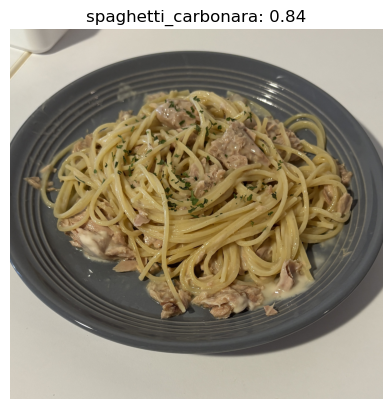

In [3]:
import shutil
import sys
sys.path.insert(0, './src')
from models.classifier import FoodClassifier
from project_utils import calculate_metrics
import plot

# Initialize the classification model
model = FoodClassifier()

# Model testing, predict a single image
example_image = './data/example.JPG'
results = model.predict_single(example_image)
plot.single_image(example_image, title=f"{results['label']}: {results['confidence']:.2f}")

Run prediction on our collected dataset as the baseline

Loaded 205 images from ./data/raw
Predicted 205 images in 7.48s


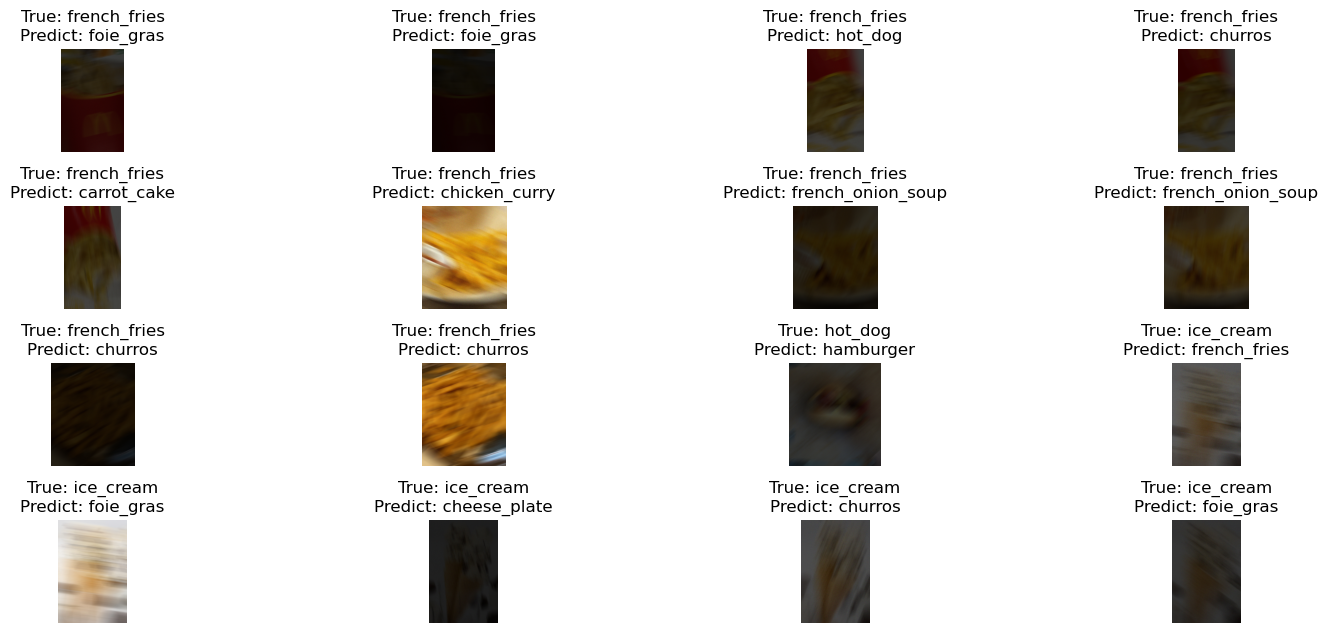

{'accuracy': 0.5658536585365853, 'f1_score': 0.6658446700550718}


In [4]:
dataset_path = './data/raw'
results = model.predict_folder(dataset_path)
plot.wrong_predictions(results, folder = dataset_path)
metrics = calculate_metrics(**results)
print(metrics)

### Part II - Individual Algorithm Evaluation

Process our collected data with the image processing algorithms. Use them as the input to the model. Find which individual algorithm performs best

In [5]:
import os 
from preprocessing.lowlight import gamma, CLAHE, SSRetinex
from preprocessing.deblurr import ssk, usm, swf
from preprocessing.downscaling import Lanczos, Lanczos_SAID, DPID
from project_utils import preprocess_folder

processor = model.processor
processor.do_resize = True
processor.do_center_crop = False

output_path = './data/preprocessed'

# Low-light
for func in [gamma, CLAHE, SSRetinex]:
    # 修正：使用 os.path.join 建立子資料夾，例如 ./data/preprocessed/gamma
    out_dir = os.path.join(output_path, func.__name__)
    preprocess_folder(func, input_dir=dataset_path, output_dir=out_dir)
    results = model.predict_folder(out_dir)
    metrics = calculate_metrics(**results)
    print(f"Metrics for {func.__name__}: {metrics}")
    # plot.wrong_predictions(results, folder = out_dir)

# 這樣 output_path (./data/preprocessed) 才會存在，rmtree 才能正常刪除
if os.path.exists(output_path):
    shutil.rmtree(output_path)

processor.do_resize = True
processor.do_center_crop = False

# Deblurring
for func in [ssk, usm, swf]:
    out_dir = os.path.join(output_path, func.__name__)
    preprocess_folder(func, input_dir=dataset_path, output_dir=out_dir)
    results = model.predict_folder(out_dir)
    metrics = calculate_metrics(**results)
    print(f"Metrics for {func.__name__}: {metrics}")
    # plot.wrong_predictions(results, folder = out_dir)

if os.path.exists(output_path):
    shutil.rmtree(output_path)

processor.do_resize = False
processor.do_center_crop = False

# Downscaling
for func in [Lanczos, Lanczos_SAID, DPID]:
    out_dir = os.path.join(output_path, func.__name__)
    preprocess_folder(func, input_dir=dataset_path, output_dir=out_dir)
    results = model.predict_folder(out_dir)
    metrics = calculate_metrics(**results)
    print(f"Metrics for {func.__name__}: {metrics}")
    # plot.wrong_predictions(results, folder = out_dir)

if os.path.exists(output_path):
    shutil.rmtree(output_path)

Loaded 205 images from ./data/preprocessed\gamma
Predicted 205 images in 14.57s
Metrics for gamma: {'accuracy': 0.5756097560975609, 'f1_score': 0.6678271677670021}
Loaded 205 images from ./data/preprocessed\CLAHE
Predicted 205 images in 13.80s
Metrics for CLAHE: {'accuracy': 0.5756097560975609, 'f1_score': 0.6880086635284361}
Loaded 205 images from ./data/preprocessed\SSRetinex
Predicted 205 images in 13.50s
Metrics for SSRetinex: {'accuracy': 0.2975609756097561, 'f1_score': 0.4352442714584815}
Loaded 205 images from ./data/preprocessed\ssk
Predicted 205 images in 14.78s
Metrics for ssk: {'accuracy': 0.551219512195122, 'f1_score': 0.6517573080750508}
Loaded 205 images from ./data/preprocessed\usm
Predicted 205 images in 13.74s
Metrics for usm: {'accuracy': 0.551219512195122, 'f1_score': 0.6554786566545715}
Loaded 205 images from ./data/preprocessed\swf
Predicted 205 images in 13.03s
Metrics for swf: {'accuracy': 0.45365853658536587, 'f1_score': 0.5325994826796637}
Loaded 205 images fro

c:\Users\Austin Chen\Desktop\UCSD\2025_Fall\ECE253\Project\ECE253-food-classification\./src\preprocessing\downscaling.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck

Loaded 205 images from ./data/preprocessed\Lanczos_SAID
Predicted 205 images in 6.21s
Metrics for Lanczos_SAID: {'accuracy': 0.5560975609756098, 'f1_score': 0.6504567606954238}
Loaded 205 images from ./data/preprocessed\DPID
Predicted 205 images in 6.13s
Metrics for DPID: {'accuracy': 0.5024390243902439, 'f1_score': 0.6202426763231333}


After finding the best algorithm of each distortion, combine them

In [6]:

preprocess_folder(CLAHE, input_dir=dataset_path, output_dir=output_path)
preprocess_folder(ssk, input_dir=output_path, output_dir=output_path)
preprocess_folder(Lanczos, input_dir=output_path, output_dir=output_path)

model.processor.do_resize = False
model.processor.do_center_crop = False

results = model.predict_folder(output_path)
metrics = calculate_metrics(**results)
print(f"Metrics for best combination: {metrics}")
# plot.wrong_predictions(results, folder = output_path)
shutil.rmtree(output_path)

Loaded 205 images from ./data/preprocessed
Predicted 205 images in 6.13s
Metrics for best combination: {'accuracy': 0.4292682926829268, 'f1_score': 0.5669924198829516}


### Part III - Combination Search

Find the best low-light - deblur - downscale combination

In [7]:
def Identity(image):
    return image
# find the best low-light - deblur - downscale combination

model.processor.do_resize = False
model.processor.do_center_crop = False

output_path = './data/preprocessed'
best_metrics = None
best_combination = None

for func1 in [Identity, gamma, CLAHE, SSRetinex]:
    for func2 in [Identity, ssk, usm, swf]:
        for func3 in [Lanczos, Lanczos_SAID, DPID]:
            preprocess_folder(func1, input_dir=dataset_path, output_dir=output_path)
            preprocess_folder(func2, input_dir=output_path, output_dir=output_path)
            preprocess_folder(func3, input_dir=output_path, output_dir=output_path)
            results = model.predict_folder(output_path)
            metrics = calculate_metrics(**results)
            print(f"Metrics for {func1.__name__} + {func2.__name__} + {func3.__name__}: {metrics}")
            # plot.wrong_predictions(results, folder = output_path)
            shutil.rmtree(output_path)

            if best_metrics is None or metrics['accuracy'] > best_metrics['accuracy']:
                best_metrics = metrics
                best_combination = (func1.__name__, func2.__name__, func3.__name__)

print(f"Best combination: {best_combination} with metrics: {best_metrics}")

Loaded 205 images from ./data/preprocessed
Predicted 205 images in 6.16s
Metrics for Identity + Identity + Lanczos: {'accuracy': 0.5756097560975609, 'f1_score': 0.6702244717777451}


c:\Users\Austin Chen\Desktop\UCSD\2025_Fall\ECE253\Project\ECE253-food-classification\./src\preprocessing\downscaling.py:226: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp_enabled, dtype=torch.float16):


Loaded 205 images from ./data/preprocessed
Predicted 205 images in 6.79s
Metrics for Identity + Identity + Lanczos_SAID: {'accuracy': 0.5560975609756098, 'f1_score': 0.6504567606954238}


KeyboardInterrupt: 

### Part IV - Model Fine-Tuning

In [ ]:
model.processor.do_resize = True
# model.processor.do_center_crop = True  


from models.trainer import fine_tune

history = fine_tune(
    model_wrapper=model,
    data_dir=dataset_path,
    val_ratio=0.3,
    epochs=20,
    batch_size=4,
    lr=5e-5
)

plot.training_history(history)